In [4]:
import torch
import random
from itertools import cycle
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from models import UNet, GaussianDiffusion
from dataset import PreloadTransformAnimalDataset
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)
print(f"Seed: {seed}")


def imshow(img):
    plt.imshow(transforms.ToPILImage()(img))
    plt.show()


base_transform = [
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.RandomAdjustSharpness(1.25, 1),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
original_transform = transforms.Compose([*base_transform])
flipped_transform = transforms.Compose(
    [
        transforms.functional.hflip,
        *base_transform,
    ]
)

dataset = PreloadTransformAnimalDataset(
    root="data/animals", split="train", transform=original_transform
)
dataset += PreloadTransformAnimalDataset(
    root="data/animals", split="train", transform=flipped_transform
)

unet = UNet(
    dim=64,
    cond_drop_prob=0.1,
    dim_mults=(1, 2, 3, 4),
    num_classes=dataset.num_classes,
)
diffusion = torch.jit.script(
    GaussianDiffusion(
        unet,
        image_size=64,
        timesteps=1000,
    )
).cuda()

Seed: 42


100%|██████████| 8/8 [00:01<00:00,  4.41it/s]


In [ ]:
from accelerate import Accelerator
from torch.optim import Adam
import os


class Trainer:
    def __init__(self, diffusion, dataset, device, save_path="model_checkpoint.pt"):
        self.accelerator = Accelerator(mixed_precision="fp16")
        self.device, self.save_path = device, save_path
        self.start = 1

        self.optimizer = Adam(diffusion.parameters(), lr=8e-5, betas=(0.9, 0.99))
        self.training_loader = DataLoader(
            dataset, batch_size=16, shuffle=True, pin_memory=True
        )
        self.diffusion, self.optimizer, self.training_loader = self.accelerator.prepare(
            diffusion, self.optimizer, self.training_loader
        )
        self.training_loader = cycle(self.training_loader)

        x, _ = next(self.training_loader)
        x = (x + 1) / 2
        imshow(utils.make_grid(x.cpu()))

    def save(self, i):
        state_dict = {
            "iteration": i,
            "diffusion": self.accelerator.get_state_dict(self.diffusion),
            "optimizer": self.optimizer.state_dict(),
            "scaler": (
                None
                if self.accelerator.scaler is None
                else self.accelerator.scaler.state_dict()
            ),
        }
        torch.save(state_dict, self.save_path)

    def load(self):
        if not os.path.exists(self.save_path):
            print("Checkpoint not found.")
            return
        checkpoint = torch.load(self.save_path, map_location=self.device)

        self.start = checkpoint["iteration"] + 1
        diffusion = self.accelerator.unwrap_model(self.diffusion)
        diffusion.load_state_dict(checkpoint["diffusion"])
        self.diffusion = torch.jit.script(diffusion)
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        if self.accelerator.scaler is not None and checkpoint["scaler"] is not None:
            self.accelerator.scaler.load_state_dict(checkpoint["scaler"])

    def train(self, num_epochs=100000):
        self.diffusion.train()
        for i in tqdm(
            range(self.start, num_epochs),
            desc="Training",
            total=num_epochs - self.start,
        ):
            data, label = next(self.training_loader)
            data, label = data.to(self.device), label.to(self.device)

            with self.accelerator.autocast():
                loss = self.diffusion(data, label)

            self.accelerator.backward(loss)
            self.optimizer.step()
            self.optimizer.zero_grad()

            if i % 10000 == 0:
                tqdm.write(f"Iteration {i}: Loss {loss.item()}")
                self.save(i)

                if i % 50000 == 0:
                    image_classes = torch.arange(0, 8).repeat(4).cuda()
                    with torch.inference_mode():
                        sampled_images = trainer.diffusion.sample(
                            classes=image_classes, cond_scale=3.5
                        )
                        sampled_images = (sampled_images + 1) / 2
                        imshow(utils.make_grid(sampled_images))


trainer = Trainer(diffusion, dataset, device)

trainer.load()
trainer.train(num_epochs=200001)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0')


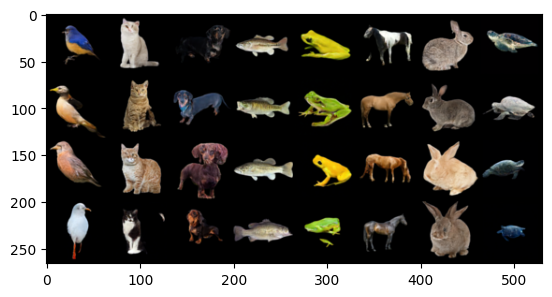

In [13]:
image_classes = torch.arange(0, 8).repeat(4).cuda()
print(image_classes)

with torch.inference_mode():
    sampled_images = trainer.diffusion.sample(classes=image_classes, cond_scale=2.5)

sampled_images = (sampled_images + 1) / 2
imshow(utils.make_grid(sampled_images))

In [11]:
utils.save_image(sampled_images, "sampled_images.png", nrow=8)

In [ ]:
print(torch.cuda.memory_summary(abbreviated=False))